<a href="https://colab.research.google.com/github/cognitedata/WiDS-2019/blob/master/WiDS_2019_Cognite_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization and Time series prediction

## What this notebook will achieve

* Extract live data from an oil rig in the North Sea.

* Visualize and inspect data directly from the Cognite Data Platform.

* Apply Linear Regression for time series prediction.


## Getting started

* Having a basic understanding of Python concepts will help to understand the process.

* Cognite has released *live* data to the public on the Cognite Data Platform streaming from [Valhall](https://www.akerbp.com/en/our-assets/production/valhall/), one of Aker's oil fields.

* To access the data, generate an API Key on [Open Industrial Data](https://openindustrialdata.com/). Get your key via the Google Access platform. You will be asked to fill out some personal information to generate your personal key.

* Visualize some of the machines (assets) on Valhall with Cognite's [Operational Intelligence](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard. This data on this page shows is streaming live data from the Valhall oil field located in the North Sea.

* To understand how to interact with the data using the Python SDK ([Docs](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/)) follow along in this notebook.

## Environment Setup

#### Install the Cognite SDK package

In [1]:
!pip install --pre cognite-sdk
!pip install --upgrade numpy

Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
    100% |████████████████████████████████| 81kB 5.7MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/fc/43/fd867e3347559845c8f993059d410c50a1e18709f1c4d4b3b47323a06a37/pandas-0.24.2-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3d/73/fe30c2daaaa0713420d0382b16fbb761409f532c56bdcc514bf7b6262bb6/pytz-2019.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
  Using cached https://files.pythonhosted.org/packages/6b/be/608b7f72b851472388eafc010a5d46dae5d41610d0ac5df4c98c2ed1b865/numpy-1.16.4-cp37-cp37m-

#### Import the required packages

In [4]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from cognite.client import CogniteClient

#### Connect to the Cognite Data Platform
* This client object is how all queries will be sent to the Cognite API to retrieve data.

When prompted for your API key, use the key generated by open industrial data as mentioned in the Getting Started steps.

In [5]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "))

Open Industrial Data API-KEY: ········


/usr/local/lib/python3.7/site-packages/cognite/client/_cognite_client.py:90: UserWarning: Authenticated towards project 'publicdata'. Specify project to suppress warning.
  "Authenticated towards project '{}'. Specify project to suppress warning.".format(self.project)


## Accessing Cognite Data Platform (CDP)
* The CDP organizes digital information about the physical world.
* There are 6 kinds of objects stored on the CDP. Each of these objects in the CDP are labelled with a unique ID. Information regarding a specific Asset, Event, etc are often retrieved using this ID.

  * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil platform.
  
  * [Event](https://doc.cognitedata.com/api/0.5/#tag/Events) objects store complex information about multiple assets over a time period. For example, an event can describe two hours of maintenance on a water pump and some associated pipes.
  
  * A [File](https://doc.cognitedata.com/api/0.5/#tag/Files) stores a sequence of bytes connected to one or more assets. For example, a file can contain a piping and instrumentation diagram (P&IDs) showing how multiple assets are connected.
  
  * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.
  
  * [Sequence](https://doc.cognitedata.com/api/0.5/#tag/Sequences) are similar to time series in that they are a key value pair, but rather than using a timestamp as the key, another measurment such as depth could be the key. For example, this is used in practice when drilling and taking measurments at various depths.
  
  * A [3D](https://doc.cognitedata.com/api/0.5/#tag/3D) model is typically built up by a hierarchical structure. This looks very similar to how we organize our internal asset hierarchy. 3D models are visualized via Cognite's dashboards.
  
* It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

### Collecting Time Series Information and Data Points

* Time Series objects contain the bulk of information in the CDP.

* Time Series objects are generally linked to an asset through the asset_id field.

* The *get_time_series()* method has a variety of filters, all are listed in the SDK.

To get all time series available in the project, we can do like this:

In [8]:
all_timeseries = client.time_series.list(limit=-1).to_pandas()
print(len(all_timeseries))
all_timeseries.head()

363


,assetId,createdTime,description,externalId,id,isStep,isString,lastUpdatedTime,name,unit
0,3424990723231138,0,PH (Profiler) Shutdown Channel 0 - Tube y Posi...,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,35246780681261,False,False,0,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,NaN
1,4293345866058133,0,PH 1stStg LO Cooler CW,VAL_45-FT-92139B:X.Value,41852231325889,False,False,0,VAL_45-FT-92139B:X.Value,NaN
2,5826132550305704,0,PH 1stStg Lube Oil Reservoir,VAL_23-LT-96182-03:X.Value,44435358976768,False,False,0,VAL_23-LT-96182-03:X.Value,NaN
3,7271158805875629,0,PH 1stStg Comp Thrust BRG IN,VAL_23-TT-96103-03:Z.X.Value,81505042780431,False,False,0,VAL_23-TT-96103-03:Z.X.Value,NaN
4,6191827428964450,0,PH (SwitchGear) MV-COMP.M. FEEDER/ 51-3 Non D...,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,82185797798532,False,False,0,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,NaN


If you are curious about which asset a time series is attached to, you can retrieve more information of the asset by:

In [11]:
client.assets.retrieve(id=2853212781345885).to_pandas()

,value
name,23-ESDV-92501A-PST
parentId,576308321452985
description,SOFT TAG VRD - PH 1STSTGSUCTCLR GAS IN
id,2853212781345885
createdTime,0
lastUpdatedTime,0
path,"[6687602007296940, 4650652196144007, 311145472..."
depth,8
ELC_STATUS_ID,1211
SOURCE_DB,workmate


#### View datapoints for one of the time series

* Now that we have a list of time series, we can retrieve datapoints for some of the them.

* A Datapoint in the CDP is stored as a key value pair

  * timestamp is the time since epoch in milliseconds
  
  * value is the reading from the sensor
  
The identifier to retrieve Datapoints is the **name** column from the DataFrame above.

In [13]:
client.datapoints.retrieve(external_id="VAL_45-PT-92508:X.Value", start="10d-ago", end="now").to_pandas().head()

,3529821833330815
2019-06-21 07:41:57.311,0.017899
2019-06-21 07:44:41.325,0.016861
2019-06-21 07:44:51.323,0.017899
2019-06-21 07:45:00.439,0.016861
2019-06-21 07:45:02.316,0.017899


## Practical use case of the data in the CDP

* When gathering data from oil platforms, specific sensors can be very expensive to install and maintain.

* A technique often used it to use a combination of other sensor readings to predict another.

* The rest of the notebook will be used to retrieve data and create the model.

#### Collect datapoints from CDP

* The following 4 columns were chosen in an effort to estimate the output pressure of the suction cooler

* Input variables:

  * FT: Input Flow Rate
  
  * PT: Input Pressure
  
  * TT: Input Temperature
  
* Output variables:

  * Output *Pressure* 
  
The time series names are defined in the *in_ts_names* and *out_ts_names* lists below.
  

In [14]:
in_ts_names = ["VAL_23-FT-92512:X.Value", "VAL_23-PT-92512:X.Value", "VAL_23-TT-92502:X.Value"]
out_ts_name = "VAL_23-PT-92504:X.Value"

#### Retrieve Data Points from CDP

* Datapoints are returned in a pandas dataframe using the method *get_datapoints_frame()*, [documentation](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html#cognite.client.stable.datapoints.DatapointsClient.get_datapoints_frame).

* The advantage of using this method over *get_datapoints()* is that the data is aggregated to a common timestamp. The processing is taken care of in the API.

* The common timestep is assigned using *granularity* argument. In this case, 1 minute was chosen.

In [21]:
ts_names = in_ts_names + [out_ts_name]

train_start_date = datetime(2018, 8, 1)
# 30 days of training data chosen arbitrarily
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.retrieve(external_id=ts_names,
                                           aggregates=['average'],
                                           granularity='1m',
                                           start=train_start_date,
                                           end=train_end_date
                                           ).to_pandas()
datapoints_df.fillna(method="ffill", inplace = True)
datapoints_df.head()

,5474031062875475|average,6156871056679530|average,7491681405625794|average,3518012501014915|average
2018-08-01 00:00:00,44.184863,3.374376,3.251437,91120.918480
2018-08-01 00:01:00,44.232420,3.395966,3.274299,86259.975220
2018-08-01 00:02:00,44.161438,3.410101,3.287578,90750.665657
2018-08-01 00:03:00,43.986025,3.358822,3.237081,91948.525170
2018-08-01 00:04:00,43.797913,3.429458,3.306391,93779.111997


In [22]:
datapoints_df.isna().any()

5474031062875475|average    False
6156871056679530|average    False
7491681405625794|average    False
3518012501014915|average    False
dtype: bool

In [23]:
# Remove "|average"
datapoints_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
datapoints_df.head()

,5474031062875475,6156871056679530,7491681405625794,3518012501014915
2018-08-01 00:00:00,44.184863,3.374376,3.251437,91120.918480
2018-08-01 00:01:00,44.232420,3.395966,3.274299,86259.975220
2018-08-01 00:02:00,44.161438,3.410101,3.287578,90750.665657
2018-08-01 00:03:00,43.986025,3.358822,3.237081,91948.525170
2018-08-01 00:04:00,43.797913,3.429458,3.306391,93779.111997


#### Visualize the Time Series data
* Utilize matplotlib to visualize each of the time series plots

The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

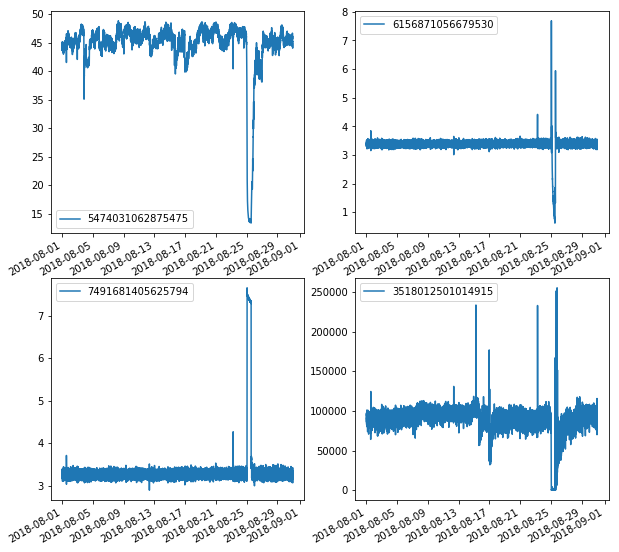

In [35]:
cols = list(datapoints_df.columns)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    datapoints_df.loc[:, [col]].plot(ax=axes[int(i>1), i%2])